In [16]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [18]:
from google.colab import files

# Upload files
uploaded = files.upload()


Saving Transactions.csv to Transactions.csv
Saving Products.csv to Products.csv
Saving Customers.csv to Customers.csv


In [19]:
# Display the uploaded files
print(uploaded.keys())


dict_keys(['Transactions.csv', 'Products.csv', 'Customers.csv'])


# Task 1: Exploratory Data Analysis (EDA)

In [20]:
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')


print("Customers Data:")
print(customers_df.head())

print("\nProducts Data:")
print(products_df.head())

print("\nTransactions Data:")
print(transactions_df.head())


Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127 

In [21]:
# Check for missing values
print(customers_df.isnull().sum())
print(products_df.isnull().sum())
print(transactions_df.isnull().sum())

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [22]:
# Summary statistics
print(customers_df.describe())
print(products_df.describe())
print(transactions_df.describe())

       CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


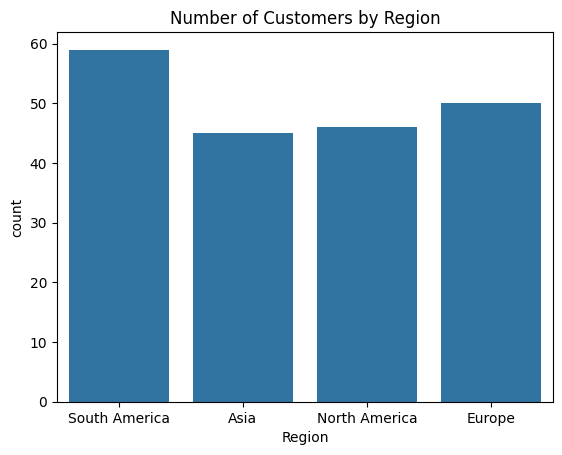

In [29]:
# Number of customers by region
sns.countplot(data=customers_df, x='Region')
plt.title('Number of Customers by Region')
plt.show()


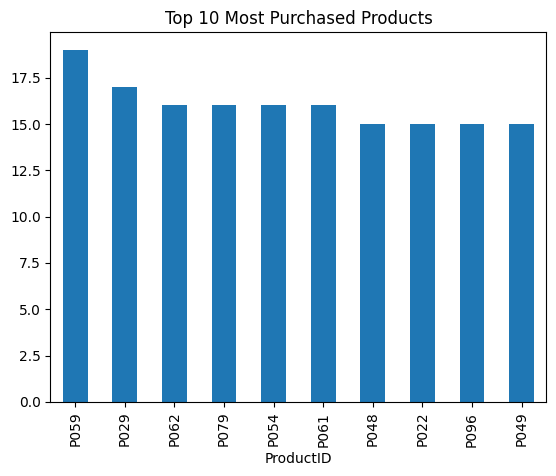

In [30]:
# Most purchased products
top_products = transactions_df['ProductID'].value_counts().head(10)
top_products.plot(kind='bar', title='Top 10 Most Purchased Products')
plt.show()

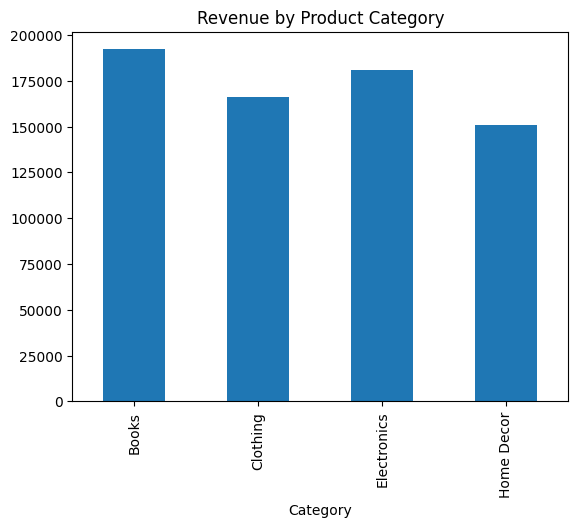

In [31]:
# Revenue by Category
revenue_category = transactions_df.merge(products_df, on='ProductID')
revenue_category = revenue_category.groupby('Category')['TotalValue'].sum()
revenue_category.plot(kind='bar', title='Revenue by Product Category')
plt.show()

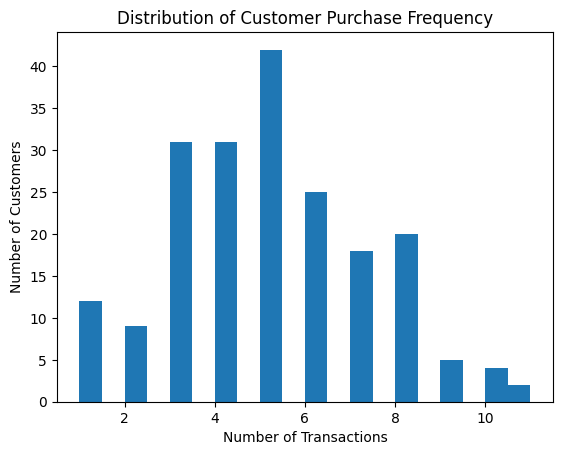

In [32]:
# Calculate the number of transactions per customer
customer_purchase_frequency = transactions_df.groupby('CustomerID').size()

# Plot the distribution of purchase frequency
customer_purchase_frequency.plot(kind='hist', bins=20, title='Distribution of Customer Purchase Frequency')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()


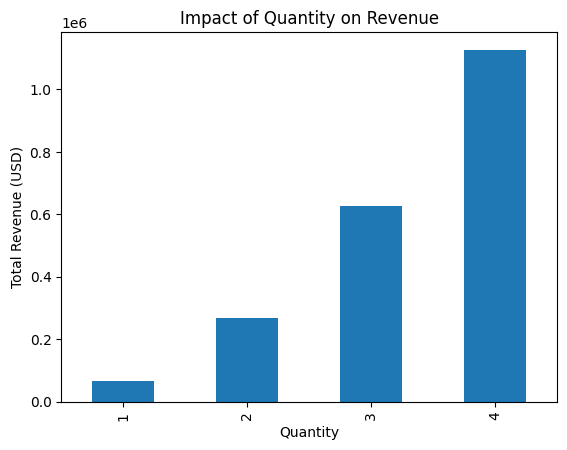

In [33]:
# Calculate total revenue by quantity purchased
transactions_df['TotalRevenue'] = transactions_df['Quantity'] * transactions_df['TotalValue']

# Group by quantity and calculate the total revenue
quantity_revenue = transactions_df.groupby('Quantity')['TotalRevenue'].sum()

# Plot the impact of quantity on revenue
quantity_revenue.plot(kind='bar', title='Impact of Quantity on Revenue')
plt.ylabel('Total Revenue (USD)')
plt.show()


**Insights:**

 **1. Impact of Quantity on Revenue:**



The total revenue increases with higher quantities purchased. Products bought in bulk (higher quantities) contribute significantly more to revenue than individual purchases, indicating that promotions or discounts on bulk purchases could further boost sales.

**2. Customer Purchase Frequency Distribution:**

The distribution of customer purchase frequency shows that a small percentage of customers make frequent purchases, while the majority purchase less often. Targeted marketing and loyalty programs could help increase repeat purchases among infrequent buyers.

**3. Revenue Concentration by Quantity:**

A few transactions with higher quantities account for a substantial portion of total revenue. This suggests that product categories with larger order volumes are crucial to driving profitability, highlighting the importance of volume-driven sales strategies.

**4. Potential for Upselling:**

Since higher quantities yield greater revenue, there is potential for upselling strategies, such as offering discounts for bulk purchases or recommending related products to encourage larger transactions.

**5. Customer Loyalty Insights:**

The number of transactions per customer is skewed, with a few customers contributing to most of the transactions. Understanding the characteristics of frequent buyers could help create personalized experiences and improve customer retention strategies.

# **Task 2: Lookalike Model**

In [35]:
#Combine Data: Merge datasets for user profiles and transaction history.
user_data = transactions_df.merge(customers_df, on='CustomerID')
user_data = user_data.merge(products_df, on='ProductID')


In [45]:
# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets on CustomerID and ProductID
merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')
merged_data = pd.merge(merged_data, products, on='ProductID', how='inner')

# Feature Engineering for Customer Profile
customer_profile = merged_data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    unique_products=('ProductID', 'nunique')
).reset_index()

# Normalize the features for similarity calculation
scaler = StandardScaler()
customer_profile_scaled = scaler.fit_transform(customer_profile[['total_spend', 'transaction_count', 'unique_products']])

# Calculate cosine similarity between customers
similarity_matrix = cosine_similarity(customer_profile_scaled)

# Create a dictionary to store the top 3 lookalikes for each customer
lookalike_dict = {}

# For each customer, find the top 3 most similar customers (excluding the customer itself)
for index, row in customer_profile.iterrows():
    customer_id = row['CustomerID']
    similarity_scores = similarity_matrix[index]

    # Exclude the customer itself from the recommendations
    similarity_scores[index] = -1

    # Get the indices of the top 3 most similar customers
    top_3_indices = similarity_scores.argsort()[-3:][::-1]
    top_3_customers = [(customer_profile.iloc[i]['CustomerID'], similarity_scores[i]) for i in top_3_indices]

    # Store the results in the dictionary
    lookalike_dict[customer_id] = top_3_customers

# Convert the dictionary into a structured format for DataFrame
lookalike_data = []

for cust_id, lookalikes in lookalike_dict.items():
    row = [cust_id]
    for lookalike in lookalikes:
        row.extend(lookalike)  # Add both customer ID and similarity score for each lookalike
    lookalike_data.append(row)

# Create DataFrame with proper column names
columns = ['CustomerID', 'Lookalike1', 'Score1', 'Lookalike2', 'Score2', 'Lookalike3', 'Score3']
lookalike_df = pd.DataFrame(lookalike_data, columns=columns)

# Save to CSV
lookalike_df.to_csv('FirstName_LastName_Lookalike.csv', index=False)

# Displaying the top 3 lookalikes for the first 20 customers
print(lookalike_df.head(20))

   CustomerID Lookalike1    Score1 Lookalike2    Score2 Lookalike3    Score3
0       C0001      C0137  0.996332      C0152  0.986905      C0056  0.930427
1       C0002      C0029  0.999758      C0199  0.999347      C0010  0.999182
2       C0003      C0178  0.999949      C0112  0.999570      C0131  0.999570
3       C0004      C0021  0.999903      C0075  0.999775      C0108  0.999315
4       C0005      C0073  0.999966      C0144  0.999954      C0095  0.999947
5       C0006      C0079  0.999897      C0117  0.991552      C0196  0.954560
6       C0007      C0085  0.999976      C0193  0.999322      C0120  0.999193
7       C0008      C0194  0.999367      C0179  0.998686      C0139  0.997697
8       C0009      C0077  0.999936      C0142  0.999642      C0032  0.999146
9       C0010      C0029  0.999830      C0025  0.999491      C0002  0.999182
10      C0011      C0183  0.994723      C0048  0.994678      C0016  0.993213
11      C0012      C0102  0.996245      C0145  0.991152      C0188  0.989816

# **Task 3: Customer Segmentation / Clustering**

DB Index: 0.7560111764268856


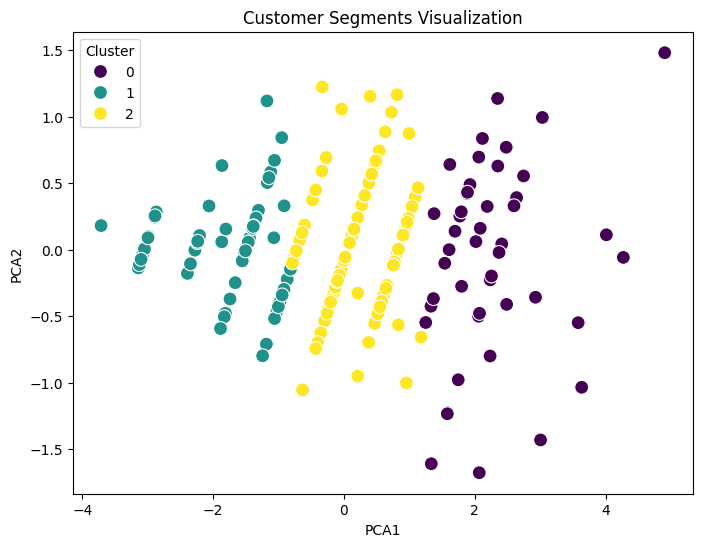

   Cluster    avg_spend  avg_transactions  avg_unique_products
0        0  5624.359783          8.086957             7.739130
1        1  1695.062576          2.651515             2.575758
2        2  3629.555455          5.147727             5.090909


In [47]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score  # Import the DB Index function
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge transaction data with customer data
customer_transactions = transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    unique_products=('ProductID', 'nunique')
).reset_index()

# Merge with customer information
data = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

# Handle missing values (if any)
data.fillna(0, inplace=True)

# Select features for clustering
features = data[['total_spend', 'transaction_count', 'unique_products']]

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Compute Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(scaled_features, data['Cluster'])
print(f"DB Index: {db_index}")

# Visualize clusters with PCA (Dimensionality Reduction)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('Customer Segments Visualization')
plt.show()

# Output cluster summary
cluster_summary = data.groupby('Cluster').agg(
    avg_spend=('total_spend', 'mean'),
    avg_transactions=('transaction_count', 'mean'),
    avg_unique_products=('unique_products', 'mean')
).reset_index()

print(cluster_summary)

# Save the result
data[['CustomerID', 'Cluster']].to_csv('Customer_Segments.csv', index=False)
